# **U-Net: Brain Tumor Segmentation**
<hr>

 **Brain Tumor**

The brain tumor is caused by abnormal cell growth in the human brain. The dominant malignant brain tumor is known as the histological glioma, and its sub-regions are tumor core, enhancing core, and whole tumor. Most of the existing brain tumor segmentation
studies focus on gliomas, the most common brain tumors in adults, and there are two types of glioma:
high-grade glioma (HGG) and low-grade glioma (LGG). [[1]](https://www.researchgate.net/publication/347808282_BU-Net_Brain_Tumor_Segmentation_Using_Modified_U-Net_Architecture)

**LGG and HGG**

Primary brain tumors are classified according to the WHO (World Health Organization) from grade I to grade IV. Grades I and II are considered low-grade tumors (LGG—low-grade glioma), while grades III and IV are highly malignant and called high-grade glioma (HGG). LGG are harder to detect in automated AI systems. LGG type I is generally benign and tends to remain unobservable and untreated in time. However, LGG type II presents the risk of recurring as a HGG, which is a much more severe and advanced phase of the cancer. [[2]](https://www.mdpi.com/2076-3417/12/7/3620/htm)

**Image segmentation for brain tumor detection**

Manual segmentation is a time consuming procedure hence automated deep learning based techniques have significantly improved the segmentation process.

The U-Net model was developed for biomedical image segmentation [[Paper]](https://arxiv.org/abs/1505.04597) and relies on use of data augmentation to use the available annotated samples more efficiently hence eliminating the need for large amounts of data for training.

The architecture consists of two paths as shown below:
- the contraction path i.e. the encoder for downsampling
- the expansion path i.e. the decoder for upsampling

In this notebook, I implement a U-Net architecture for brain tumor segmentation. The dataset lgg-mri-segmentation can be found at [this Kaggle link.](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)

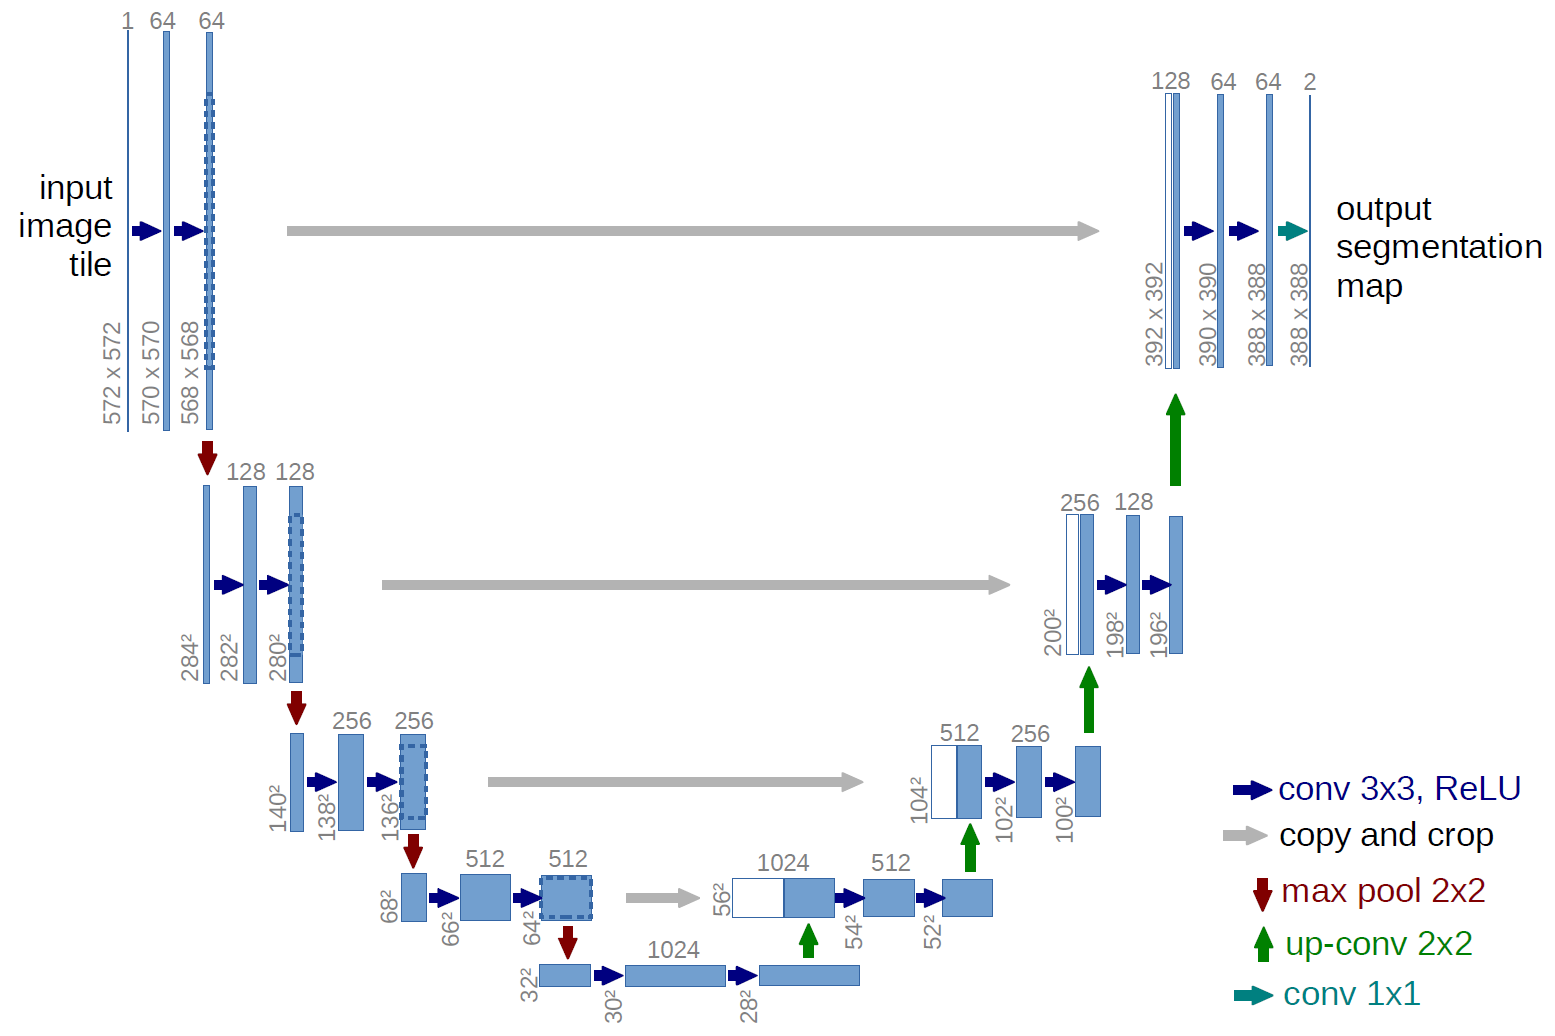

# **Importing Libraries**

In [ ]:
import os
from PIL import Image
import glob
import random
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import albumentations as A

from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from tqdm import tqdm

### **Set device**

Setting device to cuda if gpu is available

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device {} ".format(device))

Using device cuda 


### **Set seed**
Setting seed for reproducibility

In [ ]:
def set_seed(seed = 10):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

# **Importing the dataset**

In [ ]:
!pwd

/content


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

Upload your kaggle.json file before running the next cell.

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 705M/714M [00:20<00:00, 34.5MB/s]
100% 714M/714M [00:20<00:00, 37.1MB/s]


In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!unzip lgg-mri-segmentation.zip > /dev/null

# **Loading files path in a dataframe**

- Load the path of all the image files and their corresponding mask files in a dataframe.

- Create a function diagnosis which reads through all the mask files and return those files which have numpy value > 0 (not blank black mask images). Then add the list of non blank mask images with diagnosis 1 in the dataframe.

In [ ]:
ROOT_PATH = 'lgg-mri-segmentation/kaggle_3m/'

mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df.head()

,image_path,mask_path,diagnosis
0,lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19...,0
1,lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19...,1
2,lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19...,1
3,lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19...,1
4,lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_8105_19...,1


# **Understanding data distribution**

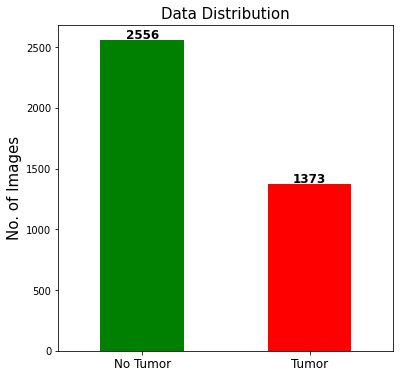

In [ ]:
ax = files_df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(6,6), color=['green', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('No. of Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)

for i, rows in enumerate(files_df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=12)

# **Train-Test-Val Split**

We use `train_test_split` from sklearn to split the data and use `stratify` parameter to evenly distribute the number of tumor positive samples among each of the sets.

In [ ]:
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train set: {}\nValidation set: {}\nTest set: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train set: (3005, 3)
Validation set: (393, 3)
Test set: (531, 3)


# **Viewing the data**

(-0.5, 1279.5, 255.5, -0.5)

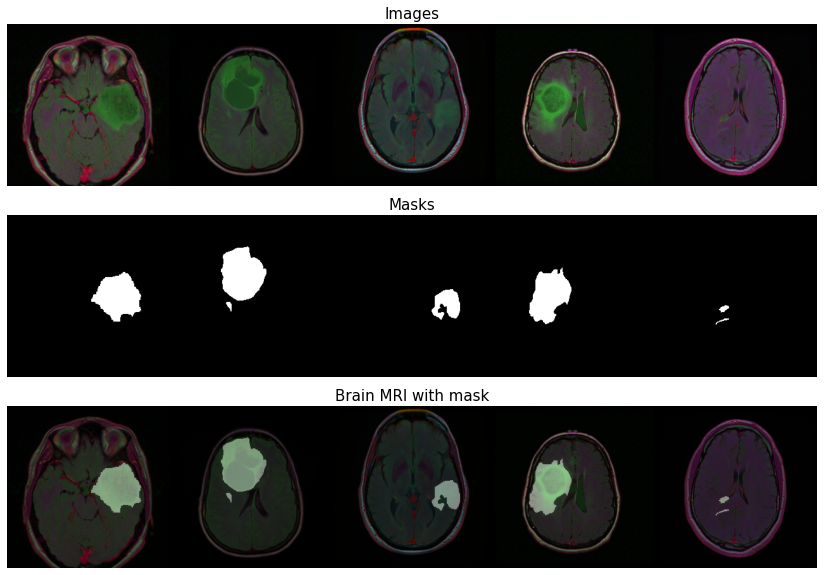

In [ ]:
set_seed()

images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(15,10))
#creating a grid of axes
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

# **Converting to PyTorch dataset format**

- Load the images & masks using cv2
- Convert them to NumPy array
- Divide by 225 so that all images/masks are in the range of [0,1]
- Apply transformations to it using the Albumentations library

In [ ]:
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        # converting from (H x W x C) to (C x H x W) format
        image = image.transpose((2,0,1))

        # converting to tensor
        image = torch.from_numpy(image).type(torch.float32)

        # using torchvision.transforms.Normalize(mean, std)
        # tuple of 3 for 3 color channels
        image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)

        # add one dimension for color channel (H, W) -> (H, W, C)
        # permute (H, W, C) -> (C, H, W)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)

        return image, mask

### **Augmentations**


In [ ]:
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

In [ ]:
set_seed()

train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)

In [ ]:
# Function to print dataset info
def dataset_info(dataset):
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(1, 40)
    img, label = dataset[index]
    print(f'Sample-{index} Image size: {img.shape}, Mask: {label.shape}\n')

In [ ]:
print('Train dataset:')
dataset_info(train_ds)

print('Validation dataset:')
dataset_info(val_ds)

print('Test dataset:')
dataset_info(test_ds)

Train dataset:
Size of dataset: 3005
Sample-37 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 393
Sample-11 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 531
Sample-24 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



# **Creating Dataloaders**

Creating dataloaders to load data in batches

In [ ]:
batch_size = 64

set_seed()

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

set_seed()

val_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

test_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

In [ ]:
images, masks = next(iter(train_dl))
print("Size of one batch: {}", images.shape)
print("Size of one batch: {}",masks.shape)

Size of one batch: {} torch.Size([64, 3, 128, 128])
Size of one batch: {} torch.Size([64, 1, 128, 128])


### **Viewing samples from a batch**

To view the samples in a batch we first denormalize the images by passing in same mean & std.

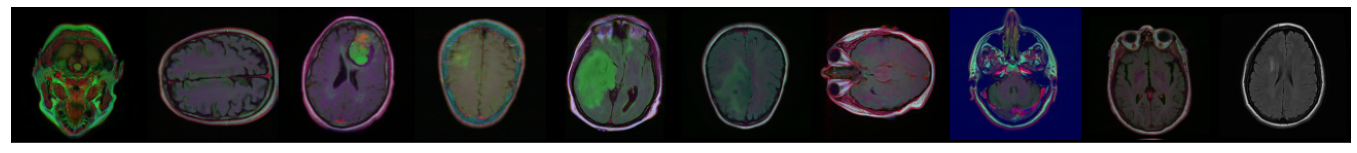

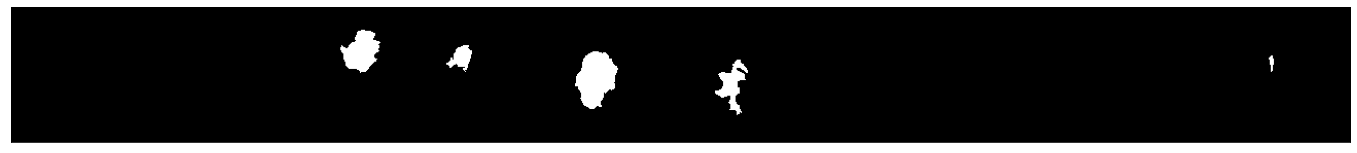

In [ ]:
def denormalize(images):
    means = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    stds = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):

    for images, masks in dl:

        fig1, ax1 = plt.subplots(figsize=(24, 24))
        ax1.set_xticks([]); ax1.set_yticks([])
        denormalized_images = denormalize(images)
        ax1.imshow(make_grid(denormalized_images[:10], nrow=10).permute(1, 2, 0).clamp(0,1))

        fig2, ax2 = plt.subplots(figsize=(24, 24))
        ax2.set_xticks([]); ax2.set_yticks([])
        ax2.imshow(make_grid(masks[:10], nrow=10).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_dl)

# **Defining the UNET model**

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => BatchNorm => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2] # [2] -> height
        diffX = x2.size()[3] - x1.size()[3] # [3] -> width
        #F = torch.nn.functional
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
model = UNet(3, 1).to(device)
out = model(torch.randn(1, 3, 128, 128).to(device))
print(out.shape)

torch.Size([1, 1, 128, 128])


# **Loss Function and Metrics**

- To measure accuracy, we use the DICE coefficient. Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images.

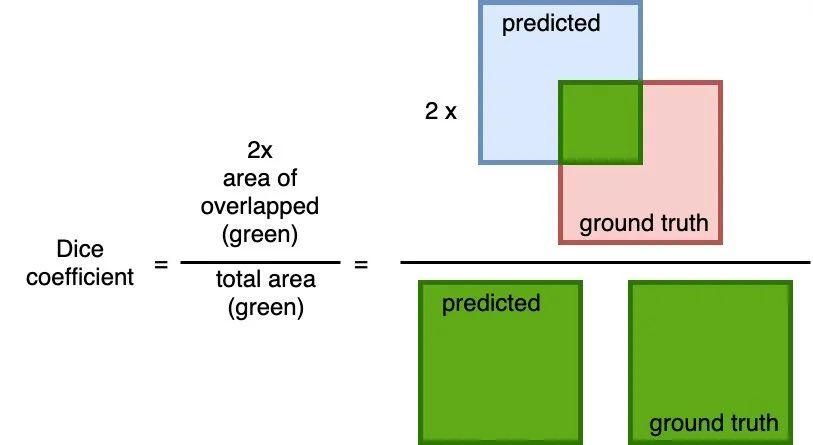
- DICE Loss is equal to `1 - DICE Coefficient`.

- However, a better loss function is the `sum of BCELoss & DICE Loss`.

In [ ]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

# **Training**

### **Train Loop**

In [ ]:
def train_loop(model, loader, loss_func):
    model.train()
    train_losses = []
    train_dices = []

#     for i, (image, mask) in enumerate(tqdm(loader)):
    for i, (image, mask) in enumerate(loader):
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return train_dices, train_losses

### **Validation Loop**

In [ ]:
def eval_loop(model, loader, loss_func, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device)
            mask = mask.to(device)

            outputs = model(image)
            loss = loss_func(outputs, mask)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())

            val_loss += loss
            val_dice += dice

        val_mean_dice = val_dice / step
        val_mean_loss = val_loss / step

        if training:
            scheduler.step(val_mean_dice)

    return val_mean_dice, val_mean_loss

### **Train Function**

In [ ]:
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history =[]
    train_dice_history =[]
    val_loss_history =[]
    val_dice_history =[]

    for epoch in range(num_epochs):

        train_dices, train_losses = train_loop(model,train_loader,loss_func)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model,val_loader,loss_func)

        train_loss_history.append(np.array(train_losses).mean())
        train_dice_history.append(np.array(train_dices).mean())
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)

        print('Epoch: {}/{} | Train Loss: {:.2f}, Validation Loss: {:.2f}, Train DICE: {:.3f}, Validation DICE: {:.3f}'.format(epoch+1, num_epochs,
                                                                                                                 train_mean_loss,
                                                                                                                 val_mean_loss,
                                                                                                                 train_mean_dice,
                                                                                                                 val_mean_dice))

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history

### **Setting Hyperparameters**

The learning rate scheduler used is `ReduceLROnPlateau` in `max` mode with `patience=3` which reduce the LR if quantity monitored stops increasing after 3 epochs.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 3

In [ ]:
%%time
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(train_dl,val_dl,bce_dice_loss,optimizer,scheduler,num_epochs)

Epoch: 1/3 | Train Loss: 1.16, Validation Loss: 1.39, Train DICE: 0.479, Validation DICE: 0.281
Epoch: 2/3 | Train Loss: 0.88, Validation Loss: 1.47, Train DICE: 0.598, Validation DICE: 0.128
Epoch: 3/3 | Train Loss: 0.63, Validation Loss: 0.59, Train DICE: 0.638, Validation DICE: 0.763
CPU times: user 2min 39s, sys: 1.64 s, total: 2min 41s
Wall time: 2min 44s


#### **Dice coefficient:** 0.763

In [ ]:
# Dice score history
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="b")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()

# Loss history
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Train Loss', lw=3, c="b")
    plt.plot(x, val_loss_history, label='Validation Loss', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()

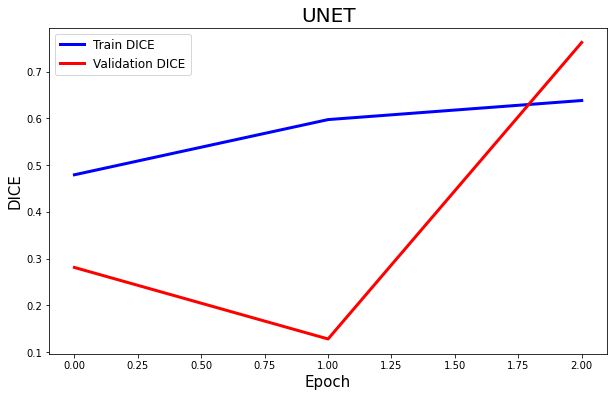

In [ ]:
plot_dice_history('UNET', train_dice_history, val_dice_history, num_epochs)

TypeError: ignored

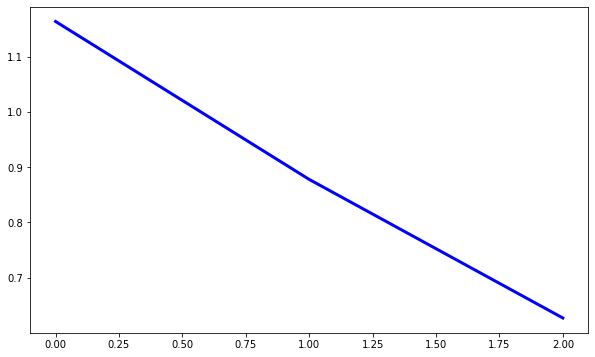

In [ ]:
plot_loss_history('UNET', train_loss_history, val_loss_history, num_epochs)

# **Prediction on Test**

In [ ]:
%%time
test_dice, test_loss = eval_loop(model, test_dl, bce_dice_loss, training=False)
print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100*test_dice), test_loss))

Mean IoU/DICE: 76.536%, Loss: 0.591
CPU times: user 2.26 s, sys: 170 ms, total: 2.42 s
Wall time: 2.85 s


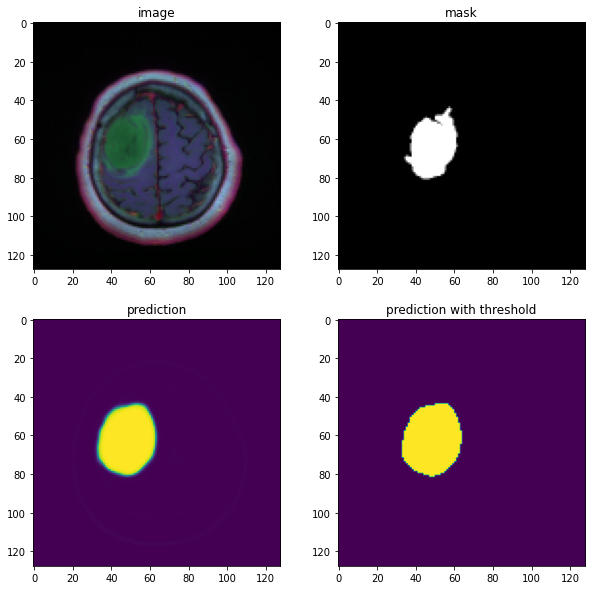

In [ ]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# predictions
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

# **Saving the model**

In [ ]:
torch.save(model.state_dict(), 'brain-mri-unet.pth')